In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import Kitti
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split


import random
%matplotlib inline

In [2]:
seed_number = 4
torch.manual_seed(seed_number)
np.random.seed(seed_number)
random.seed(seed_number)

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

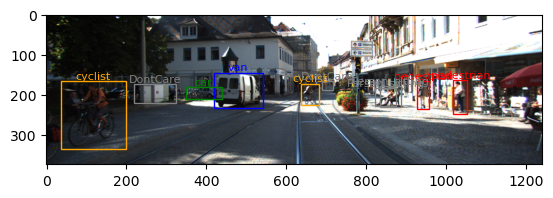

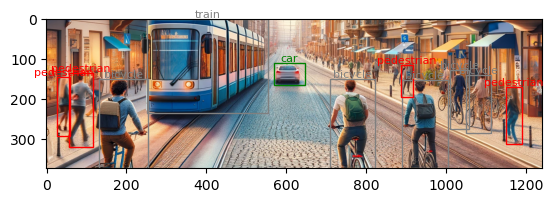

In [4]:
# Download and load the KITTI dataset
kitti_real_dataset = Kitti(root='data/data_real/',  transform=ToTensor(), download = False)
kitti_syn_dataset = Kitti(root='data/data_syn_DALLE3/',  transform=ToTensor(), download = False)

# Get the k-th image in the list () and its ground truth labels
image_index = 50
# image_index = 1 # With train errors

# Note that label_real and label_syn are the same
image_real, label_real = kitti_real_dataset[image_index]
image_syn, label_syn  = kitti_syn_dataset[image_index]

# Display the image with the bounding box
fig_real, ax = plt.subplots(1)
ax.imshow(image_real.permute(1, 2, 0))
for box in label_real:
    bbox = box["bbox"]
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]
    #x1, y1, x2, y2 = box

    if box["type"] == "Pedestrian":
        ax.text((x1+x2)/2, y1, 'pedestrian', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='red')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
    elif box["type"] == "Car":
        ax.text((x1+x2)/2, y1, 'car', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='green')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='green', linewidth=1)
    elif box["type"] == "Van":
        ax.text((x1+x2)/2, y1, 'van', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='blue')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue', linewidth=1)
    elif box["type"] == "Truck":
        ax.text((x1+x2)/2, y1, 'truck', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='orange')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='orange', linewidth=1)
    elif box["type"] == "Cyclist":
        ax.text((x1+x2)/2, y1, 'cyclist', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='orange')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='orange', linewidth=1)
    else:
        # For the other classes, we use gray
        ax.text((x1+x2)/2, y1, box["type"], ha='center', va='bottom', transform=ax.transData, fontsize=8, color='gray')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='gray', linewidth=1) 
    ax.add_patch(rect)
plt.show()

fig_syn, ax = plt.subplots(1)
ax.imshow(image_syn.permute(1, 2, 0))
for box in label_syn:
    bbox = box["bbox"]
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]
    #x1, y1, x2, y2 = box

    if (box["type"] == "Pedestrian" or box["type"] == "person"):
        ax.text((x1+x2)/2, y1, 'pedestrian', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='red')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
    elif (box["type"].lower() == "car"):
        ax.text((x1+x2)/2, y1, 'car', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='green')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='green', linewidth=1)
    elif box["type"] == "Van":
        ax.text((x1+x2)/2, y1, 'van', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='blue')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue', linewidth=1)
    elif box["type"] == "Truck":
        ax.text((x1+x2)/2, y1, 'truck', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='orange')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='orange', linewidth=1)
    elif box["type"] == "Cyclist":
        ax.text((x1+x2)/2, y1, 'cyclist', ha='center', va='bottom', transform=ax.transData, fontsize=8, color='orange')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='orange', linewidth=1)
    else:
        # For the other classes, we use gray
        ax.text((x1+x2)/2, y1, box["type"], ha='center', va='bottom', transform=ax.transData, fontsize=8, color='gray')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='gray', linewidth=1)
    ax.add_patch(rect)
plt.show()


In [5]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

C:\Users\cheng\anaconda3\envs\ML_experiment\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\cheng\anaconda3\envs\ML_experiment\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


bicycle
person
car


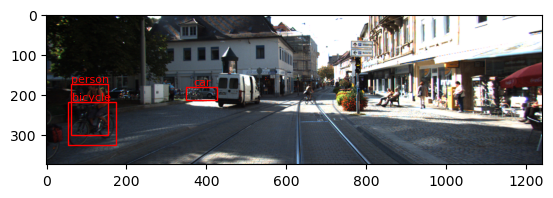

train
person


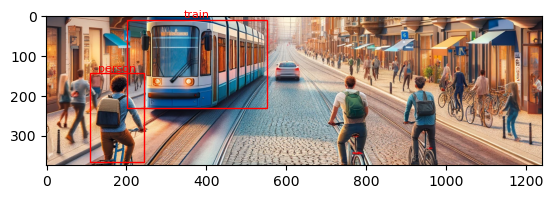

In [6]:
import torch
import torchvision
from torchvision.datasets import Kitti
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained model (note that this is not really ideal, as the model has more classes based on COCO)
model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
model.to(device)
model.eval()



# Get an image from the KITTI dataset
image_real, _ = kitti_real_dataset[image_index]
image_real = image_real.to(device)

# Generate predictions for the image
with torch.no_grad():
    prediction = model([image_real])

# Display the image with the predicted bounding boxes
image_real = image_real.cpu()
prediction = prediction[0]
boxes = prediction['boxes'].cpu().numpy()
scores = prediction['scores'].cpu().numpy()
labels = prediction['labels'].cpu().numpy()
fig, ax = plt.subplots(1)
ax.imshow(image_real.permute(1, 2, 0))
for box, score, label in zip(boxes, scores, labels):
    if score > 0.5:
        x1, y1, x2, y2 = box
        #print(label)
        ax.text((x1+x2)/2, y1, COCO_INSTANCE_CATEGORY_NAMES[label], ha='center', va='bottom', transform=ax.transData, fontsize=8, color='red')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        print(COCO_INSTANCE_CATEGORY_NAMES[label])
plt.show()


# Get an image from the KITTI dataset
image_syn, _ = kitti_syn_dataset[image_index]
image_syn = image_syn.to(device)

# Generate predictions for the image
with torch.no_grad():
    prediction = model([image_syn])

# Display the image with the predicted bounding boxes
image_syn = image_syn.cpu()
prediction = prediction[0]
boxes = prediction['boxes'].cpu().numpy()
scores = prediction['scores'].cpu().numpy()
labels = prediction['labels'].cpu().numpy()
fig, ax = plt.subplots(1)
ax.imshow(image_syn.permute(1, 2, 0))
for box, score, label in zip(boxes, scores, labels):
    if score > CONFIDENCE_THRESHOLD:

        x1, y1, x2, y2 = box
        ax.text((x1+x2)/2, y1, COCO_INSTANCE_CATEGORY_NAMES[label], ha='center', va='bottom', transform=ax.transData, fontsize=8, color='red')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        print(COCO_INSTANCE_CATEGORY_NAMES[label])
plt.show()

In [7]:
model

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [8]:
class BoundingBox:
    def __init__(self, x1, y1, x2, y2, cat = "dc"):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.cat = cat

def calculate_iou(box1, box2):
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1.x1, box2.x1)
    y_top = max(box1.y1, box2.y1)
    x_right = min(box1.x2, box2.x2)
    y_bottom = min(box1.y2, box2.y2)

    # Calculate area of intersection
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # Calculate areas of the input boxes
    box1_area = (box1.x2 - box1.x1) * (box1.y2 - box1.y1)
    box2_area = (box2.x2 - box2.x1) * (box2.y2 - box2.y1)

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou

def count_undetected_objects(ground_truths, predictions, iou_threshold, size_gt = 0):
    undetected_count = 0
    count_smaller = 0
    undetected_count_smaller = 0

    for gt_box in ground_truths:
        area = (gt_box.x2 - gt_box.x1) * (gt_box.y2 - gt_box.y1)        
        if area >= size_gt["dc"]:
            detected = False
            for pred_box in predictions:
                if calculate_iou(gt_box, pred_box) >= iou_threshold:
                    detected = True
                    break
            if not detected:
                undetected_count += 1
        else:
            count_smaller += 1
            detected = False
            for pred_box in predictions:
                if calculate_iou(gt_box, pred_box) >= iou_threshold:
                    detected = True
                    break
            if not detected:
                undetected_count_smaller += 1            


    return undetected_count, count_smaller, undetected_count_smaller



### Work on the analysis of the car/train/van/truck class

In [9]:
# Define a set of strings
real_set = {"car", "van", "truck", "train"}
syn_set = {"car", "train"}

In [11]:
AREA_THRESHOLD = {'car': 10000, 'pedestrian': 100, 'dc': 100}

bounding_boxes_real = list()
bounding_boxes_real_label = list()
bounding_boxes_syn = list()
bounding_boxes_syn_label = list()

# Get an image from the KITTI dataset
image_real, label_real = kitti_real_dataset[image_index]
image_real = image_real.to(device)

# Generate predictions for the image
with torch.no_grad():
    prediction_real = model([image_real])

# Display the image with the predicted bounding boxes
image_real = image_real.cpu()
prediction_real = prediction_real[0]
boxes_real = prediction_real['boxes'].cpu().numpy()
scores_real = prediction_real['scores'].cpu().numpy()
classes_real = prediction_real['labels'].cpu().numpy()

for box_real, score_real, class_real in zip(boxes_real, scores_real, classes_real):
    if score_real > CONFIDENCE_THRESHOLD and COCO_INSTANCE_CATEGORY_NAMES[class_real].lower() in real_set:
        x1, y1, x2, y2 = box_real
        bounding_boxes_real.append(BoundingBox(x1, y1, x2, y2))


for box in label_real:
    bbox = box["bbox"]
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]        
    if (box["type"].lower() in real_set):
        bounding_boxes_real_label.append(BoundingBox(x1, y1, x2, y2))

# Get an image from the KITTI dataset
image_syn, label_syn = kitti_syn_dataset[image_index]
image_syn = image_syn.to(device)

# Generate predictions for the image
with torch.no_grad():
    prediction = model([image_syn])

    
    
# Display the image with the predicted bounding boxes
image_syn = image_syn.cpu()
prediction_syn = prediction[0]
boxes_syn = prediction_syn['boxes'].cpu().numpy()
scores_syn = prediction_syn['scores'].cpu().numpy()
classes_syn = prediction_syn['labels'].cpu().numpy()

for box_syn, score_syn, class_syn in zip(boxes_syn, scores_syn, classes_syn):
    if score_syn > CONFIDENCE_THRESHOLD and COCO_INSTANCE_CATEGORY_NAMES[class_syn].lower() in syn_set:
        x1, y1, x2, y2 = box_syn
        bounding_boxes_syn.append(BoundingBox(x1, y1, x2, y2))

for box in label_syn:
    bbox = box["bbox"]
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]        
    if (box["type"].lower() in syn_set):
        bounding_boxes_syn_label.append(BoundingBox(x1, y1, x2, y2))
              
        
        
undetected_count_real, count_smaller_real, undetected_count_smaller = count_undetected_objects(bounding_boxes_real_label, bounding_boxes_real, IOU_THRESHOLD, AREA_THRESHOLD)
counter_larger_real = len(bounding_boxes_real_label) - count_smaller_real

print("=== Summary comparing the detector in real ===")
print("Undetected in real images by DNN (area larger than threshold):", undetected_count_real)
# print("Ground-truth smaller than threshold:", count_smaller_real)

ghost_count, _ , _ = count_undetected_objects(bounding_boxes_real, bounding_boxes_real_label, IOU_THRESHOLD, AREA_THRESHOLD)
print("Ghost objects in real images by DNN (area larger than threshold):", ghost_count)

undetected_count_syn, count_smaller_syn, undetected_count_smaller = count_undetected_objects(bounding_boxes_syn_label, bounding_boxes_syn, IOU_THRESHOLD, AREA_THRESHOLD)
counter_larger_syn = len(bounding_boxes_syn_label) - count_smaller_syn

print("=== Summary comparing the detector in syn ===")
print("Undetected in syn images by DNN (area larger than threshold):", undetected_count_syn)
# print("Ground-truth smaller than threshold:", count_smaller_syn)

ghost_count, _ , _ = count_undetected_objects(bounding_boxes_syn, bounding_boxes_syn_label, IOU_THRESHOLD, AREA_THRESHOLD)
print("Ghost objects in syn images by DNN (area larger than threshold):", ghost_count)

print("=== Performance evaluation in single image pair, based on the discrepency ratio difference on FN ===")
print("Total of objects larger than the size threshold while in the class of interest, in real: " +str( counter_larger_real))
print("Total of objects larger than the size threshold while in the class of interest, in syn: " +str( counter_larger_syn))

fn_rate_real = undetected_count_real / counter_larger_real if counter_larger_real > 0 else 0
fn_rate_syn = undetected_count_syn / counter_larger_syn if counter_larger_syn > 0 else 0
print("discrepency in FN = "+str(abs(fn_rate_real - fn_rate_syn)))

=== Summary comparing the detector in real ===
Undetected in real images by DNN (area larger than threshold): 1
Ghost objects in real images by DNN (area larger than threshold): 0
=== Summary comparing the detector in syn ===
Undetected in syn images by DNN (area larger than threshold): 1
Ghost objects in syn images by DNN (area larger than threshold): 0
=== Performance evaluation in single image pair, based on the discrepency ratio difference on FN ===
Total of objects larger than the size threshold while in the class of interest, in real: 2
Total of objects larger than the size threshold while in the class of interest, in syn: 2
discrepency in FN = 0.0


### Image processing by controlling  certain parameters

In image processing with libraries like Pillow, the parameters used for adjusting attributes like brightness, contrast, saturation, etc., often have specific ranges, usually centered around a default value that represents the unaltered state of the image. Here's a general idea of how these ranges typically work:

* Brightness: The factor usually ranges from 0 to any positive number. A factor of 1 means no change, less than 1 makes the image darker, and greater than 1 makes the image brighter. There is typically no strict upper limit, but practical values are usually close to 1 (e.g., 0.5 for darker, 1.5 for brighter).

* Contrast: Similar to brightness, a factor of 1 indicates no change. Values greater than 1 increase the contrast, and values less than 1 decrease it. The scale is generally the same as brightness.

* Saturation: Again, a value of 1 means no change. Values less than 1 desaturate the image, potentially down to 0 which would be completely grayscale. Values greater than 1 increase the saturation.

* Sharpness: A value of 1 represents the original image sharpness. Increasing the value sharpens the image, while decreasing it (down to 0) will blur the image.

* Gamma: Gamma correction doesn't have a fixed range, but it's typically a positive number. A value of 1 implies no change, while values less than 1 darken the image and values greater than 1 lighten it. The effect is nonlinear and affects mid-tones while preserving blacks and whites.

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance

In [ ]:
# Get an image from the KITTI dataset
image_syn, _ = kitti_syn_dataset[image_index]
image_syn = image_syn.to(device)

# Step 1: Convert PyTorch tensor to PIL Image
# Ensure tensor is in CPU and convert to PIL
img_pil = transforms.ToPILImage()(image_syn.cpu())

# Step 2: Enhance the image using Pillow
contrast_enhancer = ImageEnhance.Contrast(img_pil)
contrast_factor = 1
img_pil_enhanced = contrast_enhancer.enhance(contrast_factor)  # Example factor, adjust as needed

# Enhance the brightness
brightness_enhancer = ImageEnhance.Brightness(img_pil_enhanced)
brightness_factor = 1
img_pil_enhanced = brightness_enhancer.enhance(brightness_factor)  # Example factor, adjust as needed

# Enhance the saturation
saturation_enhancer = ImageEnhance.Color(img_pil_enhanced)
saturation_factor = 1
img_pil_enhanced = saturation_enhancer.enhance(saturation_factor)  # Example factor, adjust as needed

# Enhance the sharpness
sharpness_enhancer = ImageEnhance.Sharpness(img_pil_enhanced)
sharpness_factor = 1
img_pil_enhanced = sharpness_enhancer.enhance(sharpness_factor)  # Example factor, adjust as needed


# Step 3: Convert the enhanced PIL Image back to PyTorch tensor
transform = transforms.ToTensor()
image_syn_enhanced = transform(img_pil_enhanced)
image_syn_enhanced = image_syn_enhanced.to(device)

# Generate predictions for the image
with torch.no_grad():
    prediction = model([image_syn_enhanced])

# Display the image with the predicted bounding boxes
image_syn_enhanced = image_syn_enhanced.cpu()
prediction = prediction[0]
boxes = prediction['boxes'].cpu().numpy()
scores = prediction['scores'].cpu().numpy()
labels = prediction['labels'].cpu().numpy()
fig, ax = plt.subplots(1)
ax.imshow(image_syn_enhanced.permute(1, 2, 0))
for box, score, label in zip(boxes, scores, labels):
    if score > CONFIDENCE_THRESHOLD:

        x1, y1, x2, y2 = box
        ax.text((x1+x2)/2, y1, COCO_INSTANCE_CATEGORY_NAMES[label], ha='center', va='bottom', transform=ax.transData, fontsize=8, color='red')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        print(COCO_INSTANCE_CATEGORY_NAMES[label])
plt.show()

### Experiment 

Step 1, try the value with an increased interval of 0.1, from 0.8 to 1.2, making us reaching 125 tests.
Step 2, based on the result, perform local refinement with an increased interval of 0.05 (optional)

In [ ]:
import numpy as np

# Creating a list from 0.7 to 1.3 with an increment of 0.1 using numpy's arange function

# (1.1, 1.0, 0.8)

contrast_start = 0.7
contrast_end = 1.3

brightness_start = 0.7
brightness_end = 1.3

sharpness_start = 0.7
sharpness_end = 1.3

step = 0.1

contrast_elements_list = [round(i, 2) for i in np.arange(contrast_start, contrast_end + step, step)]
print(contrast_elements_list)

brightness_elements_list = [round(i, 2) for i in np.arange(brightness_start, brightness_end + step, step)]
print(brightness_elements_list)

sharpness_elements_list = [round(i, 2) for i in np.arange(sharpness_start, sharpness_end + step, step)]
print(sharpness_elements_list)

In [ ]:
AREA_THRESHOLD = {'car': 10000, 'pedestrian': 100, 'dc': 100}

In [ ]:
# Define a set of strings that we only wish to perform analysis. 
real_set = {"car", "van", "truck", "train"}
syn_set = {"car", "train"}


#### Set the range of the dataset to be iterated. 
Currently, we only have 20+ synthetic images, so we set the range to be 20. Change the number when the number of synthetic images has increased.

In [ ]:
RANGE = 20

Start the experiment

In [ ]:
min_inconsistency_ratio = 10000000
contrast, brightness, sharpness = -1, -1, -1

for contrast_factor in contrast_elements_list:
    for brightness_factor in brightness_elements_list:
        for sharpness_factor in sharpness_elements_list:
            
            inconsistency_ratio = 0
            
            for image_index in range(len(kitti_syn_dataset)):
                

                bounding_boxes_real = list()
                bounding_boxes_real_label = list()
                bounding_boxes_syn = list()
                bounding_boxes_syn_label = list()

                # Get an image from the KITTI dataset
                image_real, label_real = kitti_real_dataset[image_index]
                image_real = image_real.to(device)

                # Generate predictions for the image
                with torch.no_grad():
                    prediction_real = model([image_real])

                # Display the image with the predicted bounding boxes
                image_real = image_real.cpu()
                prediction_real = prediction_real[0]
                boxes_real = prediction_real['boxes'].cpu().numpy()
                scores_real = prediction_real['scores'].cpu().numpy()
                classes_real = prediction_real['labels'].cpu().numpy()

                for box_real, score_real, class_real in zip(boxes_real, scores_real, classes_real):
                    if score_real > CONFIDENCE_THRESHOLD and COCO_INSTANCE_CATEGORY_NAMES[class_real].lower() in real_set:
                        x1, y1, x2, y2 = box_real
                        bounding_boxes_real.append(BoundingBox(x1, y1, x2, y2))


                for box in label_real:
                    bbox = box["bbox"]
                    x1 = bbox[0]
                    y1 = bbox[1]
                    x2 = bbox[2]
                    y2 = bbox[3]        
                    if (box["type"].lower() in real_set):
                        bounding_boxes_real_label.append(BoundingBox(x1, y1, x2, y2))

                
                # Get an image from the KITTI dataset
                image_syn, label_syn = kitti_syn_dataset[image_index]

                # Step 1: Convert PyTorch tensor to PIL Image
                # Ensure tensor is in CPU and convert to PIL
                img_pil = transforms.ToPILImage()(image_syn)

                # Step 2: Enhance the image using Pillow
                contrast_enhancer = ImageEnhance.Contrast(img_pil)
                img_pil_enhanced = contrast_enhancer.enhance(contrast_factor)  

                # Enhance the brightness
                brightness_enhancer = ImageEnhance.Brightness(img_pil_enhanced)
                img_pil_enhanced = brightness_enhancer.enhance(brightness_factor)  

                # Enhance the sharpness
                sharpness_enhancer = ImageEnhance.Sharpness(img_pil_enhanced)
                img_pil_enhanced = sharpness_enhancer.enhance(sharpness_factor) 


                # Step 3: Convert the enhanced PIL Image back to PyTorch tensor
                transform = transforms.ToTensor()
                image_syn_enhanced = transform(img_pil_enhanced)
                image_syn_enhanced = image_syn_enhanced.to(device)

                # Generate predictions for the image
                with torch.no_grad():
                    prediction = model([image_syn_enhanced])
                

                image_syn = image_syn_enhanced.cpu()
                prediction_syn = prediction[0]
                boxes_syn = prediction_syn['boxes'].cpu().numpy()
                scores_syn = prediction_syn['scores'].cpu().numpy()
                classes_syn = prediction_syn['labels'].cpu().numpy()

                for box_syn, score_syn, class_syn in zip(boxes_syn, scores_syn, classes_syn):
                    if score_syn > CONFIDENCE_THRESHOLD and COCO_INSTANCE_CATEGORY_NAMES[class_syn].lower() in syn_set:
                        x1, y1, x2, y2 = box_syn
                        bounding_boxes_syn.append(BoundingBox(x1, y1, x2, y2))

                for box in label_syn:
                    bbox = box["bbox"]
                    x1 = bbox[0]
                    y1 = bbox[1]
                    x2 = bbox[2]
                    y2 = bbox[3]        
                    if (box["type"].lower() in syn_set):
                        bounding_boxes_syn_label.append(BoundingBox(x1, y1, x2, y2))
                
                undetected_count_real, count_smaller_real, undetected_count_smaller = count_undetected_objects(bounding_boxes_real_label, bounding_boxes_real, IOU_THRESHOLD, AREA_THRESHOLD)
                counter_larger_real = len(bounding_boxes_real_label) - count_smaller_real
                undetected_count_syn, count_smaller_syn, undetected_count_smaller = count_undetected_objects(bounding_boxes_syn_label, bounding_boxes_syn, IOU_THRESHOLD, AREA_THRESHOLD)
                counter_larger_syn = len(bounding_boxes_syn_label) - count_smaller_syn
            
                fn_rate_real = undetected_count_real / counter_larger_real if counter_larger_real > 0 else 0
                fn_rate_syn = undetected_count_syn / counter_larger_syn if counter_larger_syn > 0 else 0
                inconsistency_ratio = inconsistency_ratio + abs(fn_rate_real - fn_rate_syn)
            
            print(contrast_factor, brightness_factor, sharpness_factor, inconsistency_ratio, sep=', ')
            
            if (inconsistency_ratio < min_inconsistency_ratio):
                min_inconsistency_ratio = inconsistency_ratio
                contrast, brightness, sharpness = contrast_factor, brightness_factor, sharpness_factor
                


In [ ]:
print("The safe-output fidelity can be reduced by setting (contrast, brightness, sharpness) to be ("+str(contrast)+
      ", "+str(brightness)+", "+str(sharpness)+") in Pillow")

print("The minimum of safety-critical inconsistent KPI (difference in FN ratio) are "+str(min_inconsistency))

Results in optimization listed below, where the minimum occurs in the following configuration

* 0.8, 0.8, 1.4, 4.699007936507936
* 0.8, 0.9, 1.4, 4.699007936507936


When nothing occurs, 
* 1.0, 1.0, 1.0, 5.420039682539683


The worst case occurs,
0.7, 1.3, 1.3, 7.183531746031746

In [ ]:
0.7, 0.7, 0.7, 5.462896825396825
0.7, 0.7, 0.8, 5.320039682539683
0.7, 0.7, 0.9, 5.320039682539683
0.7, 0.7, 1.0, 5.2307539682539685
0.7, 0.7, 1.1, 5.341865079365079
0.7, 0.7, 1.2, 5.341865079365079
0.7, 0.7, 1.3, 5.341865079365079
0.7, 0.7, 1.4, 4.841865079365078
0.7, 0.8, 0.7, 5.462896825396825
0.7, 0.8, 0.8, 5.320039682539683
0.7, 0.8, 0.9, 5.320039682539683
0.7, 0.8, 1.0, 5.2307539682539685
0.7, 0.8, 1.1, 5.341865079365079
0.7, 0.8, 1.2, 4.841865079365078
0.7, 0.8, 1.3, 4.841865079365078
0.7, 0.8, 1.4, 4.841865079365078
0.7, 0.9, 0.7, 5.462896825396825
0.7, 0.9, 0.8, 5.320039682539683
0.7, 0.9, 0.9, 5.320039682539683
0.7, 0.9, 1.0, 5.320039682539683
0.7, 0.9, 1.1, 4.841865079365078
0.7, 0.9, 1.2, 4.841865079365078
0.7, 0.9, 1.3, 4.841865079365078
0.7, 0.9, 1.4, 4.841865079365078
0.7, 1.0, 0.7, 5.574007936507937
0.7, 1.0, 0.8, 5.462896825396825
0.7, 1.0, 0.9, 5.462896825396825
0.7, 1.0, 1.0, 5.574007936507937
0.7, 1.0, 1.1, 5.574007936507937
0.7, 1.0, 1.2, 5.574007936507937
0.7, 1.0, 1.3, 4.984722222222222
0.7, 1.0, 1.4, 5.9847222222222225
0.7, 1.1, 0.7, 5.574007936507937
0.7, 1.1, 0.8, 5.574007936507937
0.7, 1.1, 0.9, 5.574007936507937
0.7, 1.1, 1.0, 5.574007936507937
0.7, 1.1, 1.1, 5.574007936507937
0.7, 1.1, 1.2, 5.574007936507937
0.7, 1.1, 1.3, 6.574007936507936
0.7, 1.1, 1.4, 6.040674603174603
0.7, 1.2, 0.7, 5.574007936507937
0.7, 1.2, 0.8, 5.574007936507937
0.7, 1.2, 0.9, 5.574007936507937
0.7, 1.2, 1.0, 5.574007936507937
0.7, 1.2, 1.1, 5.540674603174603
0.7, 1.2, 1.2, 5.540674603174603
0.7, 1.2, 1.3, 5.540674603174603
0.7, 1.2, 1.4, 5.040674603174603
0.7, 1.3, 0.7, 5.2728174603174605
0.7, 1.3, 0.8, 5.415674603174603
0.7, 1.3, 0.9, 5.540674603174603
0.7, 1.3, 1.0, 5.874007936507936
0.7, 1.3, 1.1, 5.874007936507936
0.7, 1.3, 1.2, 6.040674603174603
0.7, 1.3, 1.3, 7.183531746031746
0.7, 1.3, 1.4, 6.594246031746032
0.7, 1.4, 0.7, 6.637896825396825
0.7, 1.4, 0.8, 6.749007936507936
0.7, 1.4, 0.9, 6.749007936507936
0.7, 1.4, 1.0, 6.874007936507936
0.7, 1.4, 1.1, 6.874007936507936
0.7, 1.4, 1.2, 7.183531746031746
0.7, 1.4, 1.3, 6.683531746031746
0.7, 1.4, 1.4, 6.580357142857143
0.8, 0.7, 0.7, 5.17718253968254
0.8, 0.7, 0.8, 5.17718253968254
0.8, 0.7, 0.9, 5.17718253968254
0.8, 0.7, 1.0, 5.087896825396825
0.8, 0.7, 1.1, 5.087896825396825
0.8, 0.7, 1.2, 5.199007936507937
0.8, 0.7, 1.3, 5.087896825396825
0.8, 0.7, 1.4, 5.199007936507937
0.8, 0.8, 0.7, 5.320039682539683
0.8, 0.8, 0.8, 5.17718253968254
0.8, 0.8, 0.9, 5.17718253968254
0.8, 0.8, 1.0, 5.17718253968254
0.8, 0.8, 1.1, 5.087896825396825
0.8, 0.8, 1.2, 5.087896825396825
0.8, 0.8, 1.3, 5.087896825396825
0.8, 0.8, 1.4, 4.699007936507936
0.8, 0.9, 0.7, 5.320039682539683
0.8, 0.9, 0.8, 5.320039682539683
0.8, 0.9, 0.9, 5.320039682539683
0.8, 0.9, 1.0, 5.320039682539683
0.8, 0.9, 1.1, 5.431150793650794
0.8, 0.9, 1.2, 5.199007936507937
0.8, 0.9, 1.3, 5.199007936507937
0.8, 0.9, 1.4, 4.699007936507936
0.8, 1.0, 0.7, 5.462896825396825
0.8, 1.0, 0.8, 5.462896825396825
0.8, 1.0, 0.9, 5.462896825396825
0.8, 1.0, 1.0, 5.462896825396825
0.8, 1.0, 1.1, 5.574007936507937
0.8, 1.0, 1.2, 5.574007936507937
0.8, 1.0, 1.3, 5.574007936507937
0.8, 1.0, 1.4, 5.574007936507937
0.8, 1.1, 0.7, 5.462896825396825
0.8, 1.1, 0.8, 5.462896825396825
0.8, 1.1, 0.9, 5.462896825396825
0.8, 1.1, 1.0, 5.574007936507937
0.8, 1.1, 1.1, 5.574007936507937
0.8, 1.1, 1.2, 5.574007936507937
0.8, 1.1, 1.3, 5.574007936507937
0.8, 1.1, 1.4, 5.540674603174603
0.8, 1.2, 0.7, 5.531150793650793
0.8, 1.2, 0.8, 5.6740079365079366
0.8, 1.2, 0.9, 5.6740079365079366
0.8, 1.2, 1.0, 5.6740079365079366
0.8, 1.2, 1.1, 5.9740079365079355
0.8, 1.2, 1.2, 5.9740079365079355
0.8, 1.2, 1.3, 5.9740079365079355
0.8, 1.2, 1.4, 5.874007936507936
0.8, 1.3, 0.7, 6.620039682539682
0.8, 1.3, 0.8, 6.620039682539682
0.8, 1.3, 0.9, 6.862896825396825
0.8, 1.3, 1.0, 6.862896825396825
0.8, 1.3, 1.1, 6.9740079365079355
0.8, 1.3, 1.2, 6.9740079365079355
0.8, 1.3, 1.3, 6.9740079365079355
0.8, 1.3, 1.4, 7.116865079365079
0.8, 1.4, 0.7, 6.762896825396825
0.8, 1.4, 0.8, 6.762896825396825
0.8, 1.4, 0.9, 6.874007936507936
0.8, 1.4, 1.0, 6.874007936507936
0.8, 1.4, 1.1, 6.9740079365079355
0.8, 1.4, 1.2, 6.9740079365079355
0.8, 1.4, 1.3, 6.9740079365079355
0.8, 1.4, 1.4, 6.4740079365079355
0.9, 0.7, 0.7, 5.17718253968254
0.9, 0.7, 0.8, 5.17718253968254
0.9, 0.7, 0.9, 5.034325396825397
0.9, 0.7, 1.0, 5.17718253968254
0.9, 0.7, 1.1, 5.087896825396825
0.9, 0.7, 1.2, 5.087896825396825
0.9, 0.7, 1.3, 5.087896825396825
0.9, 0.7, 1.4, 5.087896825396825
0.9, 0.8, 0.7, 5.17718253968254
0.9, 0.8, 0.8, 5.17718253968254
0.9, 0.8, 0.9, 5.17718253968254
0.9, 0.8, 1.0, 5.17718253968254
0.9, 0.8, 1.1, 5.17718253968254
0.9, 0.8, 1.2, 5.087896825396825
0.9, 0.8, 1.3, 5.087896825396825
0.9, 0.8, 1.4, 5.087896825396825
0.9, 0.9, 0.7, 5.17718253968254
0.9, 0.9, 0.8, 5.320039682539683
0.9, 0.9, 0.9, 5.320039682539683
0.9, 0.9, 1.0, 5.320039682539683
0.9, 0.9, 1.1, 5.320039682539683
0.9, 0.9, 1.2, 5.320039682539683
0.9, 0.9, 1.3, 5.320039682539683
0.9, 0.9, 1.4, 5.431150793650794
0.9, 1.0, 0.7, 5.320039682539683
0.9, 1.0, 0.8, 5.320039682539683
0.9, 1.0, 0.9, 5.420039682539683
0.9, 1.0, 1.0, 5.420039682539683
0.9, 1.0, 1.1, 5.531150793650793
0.9, 1.0, 1.2, 5.531150793650793
0.9, 1.0, 1.3, 5.531150793650793
0.9, 1.0, 1.4, 5.531150793650793
0.9, 1.1, 0.7, 5.420039682539683
0.9, 1.1, 0.8, 5.420039682539683
0.9, 1.1, 0.9, 5.562896825396825
0.9, 1.1, 1.0, 5.896230158730158
0.9, 1.1, 1.1, 6.00734126984127
0.9, 1.1, 1.2, 6.00734126984127
0.9, 1.1, 1.3, 5.9740079365079355
0.9, 1.1, 1.4, 5.9740079365079355
0.9, 1.2, 0.7, 5.753373015873016
0.9, 1.2, 0.8, 5.753373015873016
0.9, 1.2, 0.9, 5.753373015873016
0.9, 1.2, 1.0, 5.862896825396825
0.9, 1.2, 1.1, 5.9740079365079355
0.9, 1.2, 1.2, 5.9740079365079355
0.9, 1.2, 1.3, 5.9740079365079355
0.9, 1.2, 1.4, 5.9740079365079355
0.9, 1.3, 0.7, 5.4771825396825395
0.9, 1.3, 0.8, 5.577182539682539
0.9, 1.3, 0.9, 5.7200396825396815
0.9, 1.3, 1.0, 6.7200396825396815
0.9, 1.3, 1.1, 6.831150793650792
0.9, 1.3, 1.2, 6.831150793650792
0.9, 1.3, 1.3, 6.831150793650792
0.9, 1.3, 1.4, 6.831150793650792
0.9, 1.4, 0.7, 5.4771825396825395
0.9, 1.4, 0.8, 5.620039682539682
0.9, 1.4, 0.9, 5.620039682539682
0.9, 1.4, 1.0, 5.7311507936507935
0.9, 1.4, 1.1, 5.7311507936507935
0.9, 1.4, 1.2, 5.7311507936507935
0.9, 1.4, 1.3, 5.831150793650793
0.9, 1.4, 1.4, 6.331150793650792
1.0, 0.7, 0.7, 5.17718253968254
1.0, 0.7, 0.8, 5.17718253968254
1.0, 0.7, 0.9, 5.034325396825397
1.0, 0.7, 1.0, 5.034325396825397
1.0, 0.7, 1.1, 5.034325396825397
1.0, 0.7, 1.2, 4.945039682539682
1.0, 0.7, 1.3, 4.945039682539682
1.0, 0.7, 1.4, 4.945039682539682
1.0, 0.8, 0.7, 5.17718253968254
1.0, 0.8, 0.8, 5.17718253968254
1.0, 0.8, 0.9, 5.17718253968254
1.0, 0.8, 1.0, 5.17718253968254
1.0, 0.8, 1.1, 5.034325396825397
1.0, 0.8, 1.2, 5.134325396825397
1.0, 0.8, 1.3, 5.17718253968254
1.0, 0.8, 1.4, 5.187896825396825
1.0, 0.9, 0.7, 5.134325396825397
1.0, 0.9, 0.8, 5.134325396825397
1.0, 0.9, 0.9, 5.420039682539683
1.0, 0.9, 1.0, 5.420039682539683
1.0, 0.9, 1.1, 5.420039682539683
1.0, 0.9, 1.2, 5.420039682539683
1.0, 0.9, 1.3, 5.420039682539683
1.0, 0.9, 1.4, 5.420039682539683
1.0, 1.0, 0.7, 5.134325396825397
1.0, 1.0, 0.8, 5.277182539682539
1.0, 1.0, 0.9, 5.277182539682539
1.0, 1.0, 1.0, 5.420039682539683
1.0, 1.0, 1.1, 5.420039682539683
1.0, 1.0, 1.2, 5.420039682539683
1.0, 1.0, 1.3, 5.420039682539683
1.0, 1.0, 1.4, 5.864484126984126
1.0, 1.1, 0.7, 5.277182539682539
1.0, 1.1, 0.8, 5.610515873015872
1.0, 1.1, 0.9, 5.610515873015872
1.0, 1.1, 1.0, 5.610515873015872
1.0, 1.1, 1.1, 5.753373015873016
1.0, 1.1, 1.2, 5.896230158730159
1.0, 1.1, 1.3, 5.862896825396825
1.0, 1.1, 1.4, 5.974007936507936
1.0, 1.2, 0.7, 5.46765873015873
1.0, 1.2, 0.8, 5.46765873015873
1.0, 1.2, 0.9, 5.46765873015873
1.0, 1.2, 1.0, 5.577182539682539
1.0, 1.2, 1.1, 5.608928571428571
1.0, 1.2, 1.2, 5.608928571428571
1.0, 1.2, 1.3, 5.720039682539682
1.0, 1.2, 1.4, 5.720039682539682
1.0, 1.3, 0.7, 5.4771825396825395
1.0, 1.3, 0.8, 5.4771825396825395
1.0, 1.3, 0.9, 5.4771825396825395
1.0, 1.3, 1.0, 5.577182539682539
1.0, 1.3, 1.1, 5.831150793650793
1.0, 1.3, 1.2, 5.831150793650793
1.0, 1.3, 1.3, 5.831150793650793
1.0, 1.3, 1.4, 5.831150793650793
1.0, 1.4, 0.7, 5.653373015873016
1.0, 1.4, 0.8, 5.653373015873016
1.0, 1.4, 0.9, 5.796230158730159
1.0, 1.4, 1.0, 5.796230158730159
1.0, 1.4, 1.1, 5.7311507936507935
1.0, 1.4, 1.2, 5.7311507936507935
1.0, 1.4, 1.3, 5.831150793650793
1.0, 1.4, 1.4, 5.331150793650793
1.1, 0.7, 0.7, 5.034325396825397
1.1, 0.7, 0.8, 5.17718253968254
1.1, 0.7, 0.9, 5.034325396825397
1.1, 0.7, 1.0, 5.034325396825397
1.1, 0.7, 1.1, 5.034325396825397
1.1, 0.7, 1.2, 5.045039682539683
1.1, 0.7, 1.3, 4.945039682539682
1.1, 0.7, 1.4, 5.045039682539683
1.1, 0.8, 0.7, 5.134325396825397
1.1, 0.8, 0.8, 5.277182539682539
1.1, 0.8, 0.9, 5.277182539682539
1.1, 0.8, 1.0, 5.277182539682539
1.1, 0.8, 1.1, 5.277182539682539
1.1, 0.8, 1.2, 5.134325396825397
1.1, 0.8, 1.3, 5.134325396825397
1.1, 0.8, 1.4, 5.277182539682539
1.1, 0.9, 0.7, 5.134325396825397
1.1, 0.9, 0.8, 5.27718253968254
1.1, 0.9, 0.9, 5.27718253968254
1.1, 0.9, 1.0, 5.562896825396826
1.1, 0.9, 1.1, 5.277182539682539
1.1, 0.9, 1.2, 5.420039682539683
1.1, 0.9, 1.3, 5.420039682539683
1.1, 0.9, 1.4, 5.420039682539683
1.1, 1.0, 0.7, 5.27718253968254
1.1, 1.0, 0.8, 5.753373015873016
1.1, 1.0, 0.9, 5.753373015873016
1.1, 1.0, 1.0, 5.753373015873016
1.1, 1.0, 1.1, 5.896230158730159
1.1, 1.0, 1.2, 5.896230158730159
1.1, 1.0, 1.3, 5.896230158730159
1.1, 1.0, 1.4, 5.896230158730159
1.1, 1.1, 0.7, 5.134325396825397
1.1, 1.1, 0.8, 5.27718253968254
1.1, 1.1, 0.9, 5.610515873015873
1.1, 1.1, 1.0, 5.610515873015873
1.1, 1.1, 1.1, 5.499404761904762
1.1, 1.1, 1.2, 5.642261904761905
1.1, 1.1, 1.3, 5.642261904761905
1.1, 1.1, 1.4, 5.753373015873016
1.1, 1.2, 0.7, 5.46765873015873
1.1, 1.2, 0.8, 5.46765873015873
1.1, 1.2, 0.9, 5.610515873015873
1.1, 1.2, 1.0, 5.610515873015873
1.1, 1.2, 1.1, 5.753373015873016
1.1, 1.2, 1.2, 5.753373015873016
1.1, 1.2, 1.3, 5.864484126984127
1.1, 1.2, 1.4, 5.831150793650793
1.1, 1.3, 0.7, 5.510515873015873
1.1, 1.3, 0.8, 5.653373015873016
1.1, 1.3, 0.9, 5.653373015873016
1.1, 1.3, 1.0, 5.510515873015874
1.1, 1.3, 1.1, 5.753373015873016
1.1, 1.3, 1.2, 5.864484126984127
1.1, 1.3, 1.3, 5.864484126984127
1.1, 1.3, 1.4, 5.721626984126984
1.1, 1.4, 0.7, 5.4771825396825395
1.1, 1.4, 0.8, 5.4771825396825395
1.1, 1.4, 0.9, 5.334325396825397
1.1, 1.4, 1.0, 5.358134920634921
1.1, 1.4, 1.1, 5.612103174603175
1.1, 1.4, 1.2, 5.754960317460317
1.1, 1.4, 1.3, 5.388293650793651
1.1, 1.4, 1.4, 5.388293650793651
1.2, 0.7, 0.7, 5.17718253968254
1.2, 0.7, 0.8, 5.17718253968254
1.2, 0.7, 0.9, 5.17718253968254
1.2, 0.7, 1.0, 5.17718253968254
1.2, 0.7, 1.1, 5.087896825396825
1.2, 0.7, 1.2, 5.087896825396825
1.2, 0.7, 1.3, 5.087896825396825
1.2, 0.7, 1.4, 5.087896825396825
1.2, 0.8, 0.7, 5.277182539682539
1.2, 0.8, 0.8, 5.134325396825397
1.2, 0.8, 0.9, 5.134325396825397
1.2, 0.8, 1.0, 5.134325396825397
1.2, 0.8, 1.1, 5.277182539682539
1.2, 0.8, 1.2, 5.277182539682539
1.2, 0.8, 1.3, 5.187896825396825
1.2, 0.8, 1.4, 5.187896825396825
1.2, 0.9, 0.7, 5.420039682539683
1.2, 0.9, 0.8, 5.420039682539683
1.2, 0.9, 0.9, 5.420039682539683
1.2, 0.9, 1.0, 5.420039682539683
1.2, 0.9, 1.1, 5.27718253968254
1.2, 0.9, 1.2, 5.420039682539683
1.2, 0.9, 1.3, 5.420039682539683
1.2, 0.9, 1.4, 5.308928571428572
1.2, 1.0, 0.7, 5.27718253968254
1.2, 1.0, 0.8, 5.308928571428572
1.2, 1.0, 0.9, 5.642261904761905
1.2, 1.0, 1.0, 5.451785714285714
1.2, 1.0, 1.1, 5.166071428571429
1.2, 1.0, 1.2, 5.308928571428572
1.2, 1.0, 1.3, 5.451785714285714
1.2, 1.0, 1.4, 5.785119047619047
1.2, 1.1, 0.7, 5.46765873015873
1.2, 1.1, 0.8, 5.610515873015873
1.2, 1.1, 0.9, 5.610515873015873
1.2, 1.1, 1.0, 5.753373015873016
1.2, 1.1, 1.1, 5.610515873015873
1.2, 1.1, 1.2, 5.610515873015873
1.2, 1.1, 1.3, 5.753373015873016
1.2, 1.1, 1.4, 5.753373015873016
1.2, 1.2, 0.7, 5.510515873015873
1.2, 1.2, 0.8, 5.653373015873016
1.2, 1.2, 0.9, 5.653373015873016
1.2, 1.2, 1.0, 5.753373015873016
1.2, 1.2, 1.1, 5.753373015873016
1.2, 1.2, 1.2, 5.753373015873016
1.2, 1.2, 1.3, 5.562896825396825
1.2, 1.2, 1.4, 5.674007936507936
1.2, 1.3, 0.7, 5.510515873015874
1.2, 1.3, 0.8, 5.510515873015874
1.2, 1.3, 0.9, 5.510515873015874
1.2, 1.3, 1.0, 5.653373015873016
1.2, 1.3, 1.1, 5.753373015873016
1.2, 1.3, 1.2, 5.896230158730159
1.2, 1.3, 1.3, 5.896230158730159
1.2, 1.3, 1.4, 6.00734126984127
1.2, 1.4, 0.7, 5.215277777777778
1.2, 1.4, 0.8, 5.215277777777778
1.2, 1.4, 0.9, 5.35813492063492
1.2, 1.4, 1.0, 5.500992063492063
1.2, 1.4, 1.1, 5.500992063492063
1.2, 1.4, 1.2, 5.712103174603174
1.2, 1.4, 1.3, 5.212103174603174
1.2, 1.4, 1.4, 5.212103174603174
1.3, 0.7, 0.7, 5.17718253968254
1.3, 0.7, 0.8, 5.17718253968254
1.3, 0.7, 0.9, 5.17718253968254
1.3, 0.7, 1.0, 5.17718253968254
1.3, 0.7, 1.1, 5.320039682539682